# 3 | User Churn Prediction — Model Training & Evaluation

This script trains an XGBoost binary classification model to predict user churn and evaluates its performance. It includes:

1. **Imports & I/O**
   Load feature CSV, set up file paths, and define constants.

2. **Feature Loading & Preprocessing**
   Read `user_churn_features.csv`, compute `days_since_last_review`, convert boolean columns, and ensure all features are numeric.

3. **Train/Test Split**
   Load precomputed train/test user ID lists and split the feature table accordingly.

4. **DMatrix Construction**
   Build `xgb.DMatrix` objects for training and evaluation, with explicit `feature_names`.

5. **Model Training**
   Configure XGBoost parameters (including `scale_pos_weight`), train with early stopping, and log AUC.

6. **Evaluation & Metrics**
   Predict probabilities on the test set, compute ACC, Precision, Recall, F1, and AUC, and prepare for downstream Precision–Recall curve plotting.


In [1]:
# 0 | Imports & IO
from pathlib import Path
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

PROC      = Path("../data/processed")
MODEL_DIR = Path("../models"); MODEL_DIR.mkdir(exist_ok=True)

T_END = pd.Timestamp("2022-01-19")

In [2]:
# 1A | Load Feature Table & Convert to Numeric
feat_df = pd.read_csv(PROC/"user_churn_features.csv",
                      parse_dates=["last_review_date"])

feat_df = feat_df.drop(columns=["last_review_date"])

bool_cols = feat_df.select_dtypes("bool").columns
feat_df[bool_cols] = feat_df[bool_cols].astype("int8")

assert feat_df.drop(columns=["user_id"]).dtypes.apply(lambda dt: dt.kind in "if").all()

In [20]:
# 1B | Load the feature table & split the training/test sets
train_ids = pd.read_csv(PROC/"train_user_ids.txt", header=None)[0]
test_ids  = pd.read_csv(PROC/"test_user_ids.txt",  header=None)[0]

train_df = feat_df[feat_df["user_id"].isin(train_ids)].copy()
test_df  = feat_df[feat_df["user_id"].isin(test_ids)].copy()

X_train, y_train = train_df.drop(columns=["user_id", "churn_label"]), train_df["churn_label"]
X_test,  y_test  = test_df .drop(columns=["user_id", "churn_label"]),  test_df ["churn_label"]

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Label distribution (train):\n", y_train.value_counts())
print("Label distribution (test):\n", y_test.value_counts())

Train shape: (1689739, 15)  Test shape: (298190, 15)
Label distribution (train):
 churn_label
1    1420221
0     269518
Name: count, dtype: int64
Label distribution (test):
 churn_label
1    250628
0     47562
Name: count, dtype: int64


In [7]:
# 3 Construct DMatrix
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

dtrain = xgb.DMatrix(X_tr,  label=y_tr)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

In [15]:
# 4 | train XGBoost
pos, neg = y_tr.sum(), len(y_tr) - y_tr.sum()
params = {
    "objective":        "binary:logistic",
    "eval_metric":      "auc",
    "eta":              0.08,
    "max_depth":        6,
    "subsample":        0.8,
    "colsample_bytree": 0.8,
    "scale_pos_weight": neg / pos,
    "seed":             42,
}


watch = [(dtrain, "train"), (dval, "val")]
model = xgb.train(
    params, dtrain,
    num_boost_round=800,
    evals=watch,
    early_stopping_rounds=50,
    verbose_eval=50
)

[0]	train-auc:0.72797	val-auc:0.72329
[50]	train-auc:0.76256	val-auc:0.75867
[100]	train-auc:0.76748	val-auc:0.76234
[150]	train-auc:0.77061	val-auc:0.76396
[200]	train-auc:0.77264	val-auc:0.76469
[250]	train-auc:0.77430	val-auc:0.76509
[300]	train-auc:0.77572	val-auc:0.76532
[350]	train-auc:0.77705	val-auc:0.76546
[400]	train-auc:0.77832	val-auc:0.76558
[450]	train-auc:0.77944	val-auc:0.76553
[457]	train-auc:0.77960	val-auc:0.76553


In [18]:
# 5 | Evaluation
proba = model.predict(dtest, iteration_range=(0, model.best_iteration+1))
pred  = (proba >= 0.5).astype(int)

print("ACC =", accuracy_score(y_test, pred))
print("PRE =", precision_score(y_test, pred))
print("REC =", recall_score(y_test, pred))
print("F1  =", f1_score(y_test, pred))
print("AUC =", roc_auc_score(y_test, proba))

ACC = 0.7481370937992555
PRE = 0.9145117487306648
REC = 0.7725593309606269
F1  = 0.8375635066713096
AUC = 0.7697792177629627


In [19]:
model.save_model(MODEL_DIR / "churn_xgb_model.json")
print("✅ Model saved.")

✅ Model saved.


In [21]:
print("== label distribution ==")
print("train label counts:\n", y_train.value_counts(dropna=False))
print("test  label counts:\n", y_test .value_counts(dropna=False))
print("\n== row ==")
print("train_df rows:", len(train_df))
print("test_df  rows:", len(test_df))


== label distribution ==
train label counts:
 churn_label
1    1420221
0     269518
Name: count, dtype: int64
test  label counts:
 churn_label
1    250628
0     47562
Name: count, dtype: int64

== row ==
train_df rows: 1689739
test_df  rows: 298190


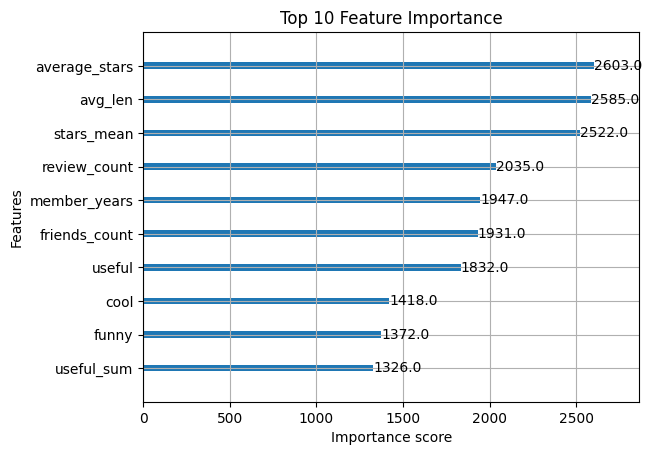

In [23]:
# 6 Metrics
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importance")
plt.show()


Confusion Matrix:
 [[ 29462  18100]
 [ 57003 193625]]


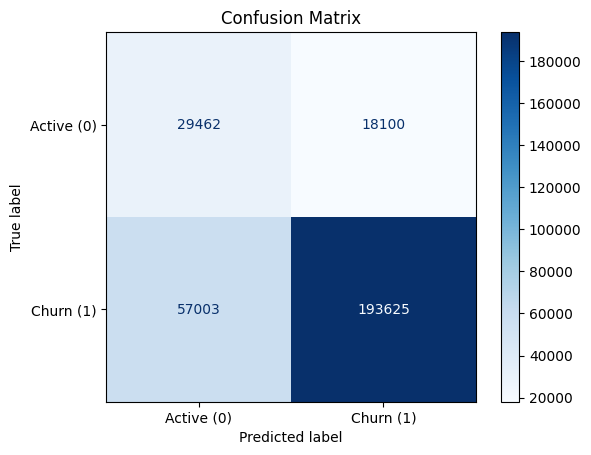

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred, labels=[0, 1])
print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Active (0)", "Churn (1)"])
disp.plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

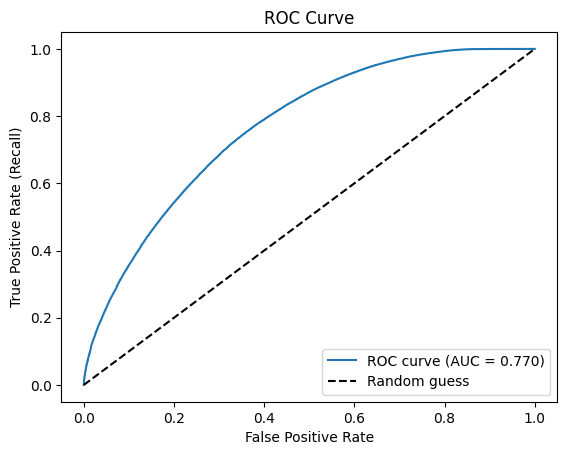

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve coordinates and AUC
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = roc_auc_score(y_test, proba)
# lot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

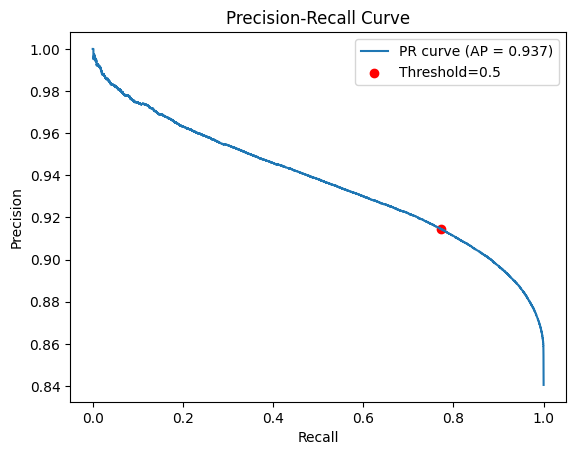

In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Plot the Precision-Recall curve and mark the point at threshold = 0.5
precision, recall, thresholds = precision_recall_curve(y_test, proba)
ap = average_precision_score(y_test, proba)
plt.figure()
plt.plot(recall, precision, label=f"PR curve (AP = {ap:.3f})")
# 标记当前决策阈值=0.5点的位置
plt.scatter(recall_score(y_test, pred), precision_score(y_test, pred),
            color='red', label=f"Threshold=0.5")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.show()